# AI CALCULATOR

## Libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random
import numpy as np

%matplotlib inline

# let's hope we got tensorflow 2 installed
# Other wise  !pip install tensorflow-gpu==2.0.0
import tensorflow as tf
tf.__version__

'2.0.0'

## Path lead to photos

In [3]:
#!unzip data.zip

In [4]:
# create a path to data folder
data_root = pathlib.Path('./first_half_mul')

In [ ]:
# double check our current directory
!dir

#### Take all images and paths lead to these images

In [5]:
# Find all image's path
all_image_paths = list(data_root.glob("**/*"))

# check if the path contains file
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]

# time to shuffle our data
random.shuffle(all_image_paths)

#### Total images

In [6]:
# total images
image_count = len(all_image_paths)
image_count

10089

In [7]:
# read image files and ignore DS_Store
for index, image_path in enumerate(all_image_paths):
    if (image_path.split('.')[1] != "DS_Store") :
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
        except:
            print(all_image_paths[index])
        if index % 3000 == 0: 
            print(index)
    else:
        all_image_paths.remove(image_path)

0
3000
6000
9000


### Take labels

In [36]:
# get labels from folder names
label_names = sorted(item.name for item in data_root.glob('**/') if item.is_dir())

label_names = np.array(label_names)
label_names

array(['0', '1', '10', '2', '3', '4', '5', 'first_half_mul'], dtype='<U14')

In [37]:
# might have to remove stuffs from unrelevant labels
# label_names.remove('.ipynb_checkpoints')
# label_names=label_names[:-2].astype(int)
label_names=label_names[:-1]

In [38]:
label_names.astype(int)

array([ 0,  1, 10,  2,  3,  4,  5])

In [44]:
label_names = label_names.astype(int)

In [45]:
label_names

array([ 0,  1, 10,  2,  3,  4,  5])

In [46]:
# we want the label to be in order so we dont need to remember the order it appear 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 ...
label_names.sort()

In [47]:
# make sure the label in nice order
label_names

array([ 0,  1,  2,  3,  4,  5, 10])

### Set index for labels

In [52]:
# create dictionary for prediction index to real label (in our case, it happens to be very similar on both side)
label_to_index = dict((str(name), index) for index, name in enumerate(label_names))
label_to_index

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '10': 6}

### Set label for each image

In [53]:
# Find all image's labels from all_image_paths
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

# get the first 10 lables to check if the random shuffle actually work
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 2, 1, 2, 0, 6, 5, 4, 6, 6]


### Count amount per class

In [54]:
# Count number of images from each class
from collections import Counter
count = Counter()

for label in all_image_labels:
    count[label_names[label]] += 1
  
count

Counter({4: 993, 2: 901, 1: 1435, 0: 1266, 10: 3771, 5: 909, 3: 814})

## Functions

In [55]:
# preprocessing image: decode_jpeg with 3 channels, rgb_to_grayscale, resize to (28,28) then standard by /255.
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = (255 - image)/255.0

    return image

# load and use preprocess_image function
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

first_half_mul\10\exp63003.jpg


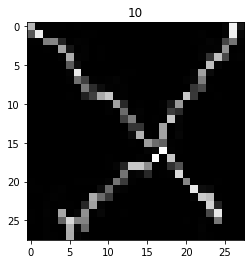

In [56]:
# pick a random image and show it
index = random.randint(0, image_count)
image_path = all_image_paths[index]
label = all_image_labels[index]

# show path file
print(image_path)

# show image
plt.imshow(load_and_preprocess_image(image_path)[:,:,0], cmap='gray')
plt.grid(False)
plt.title(label_names[label])
plt.show()

In [57]:
# split the data for train set and test set
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.2, random_state=101)

In [58]:
test_image_paths[0]
test_image_labels[0]

3

In [59]:
# The tuples are unpacked into the positional arguments of the mapped function (keras requires this)
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# creating dataset
def create_ds(all_image_paths, all_image_labels):
    
    # prepare the dataset for pipeline with tensor_slices
    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    
    # map the load_and_preprocess_from_path_label function to the pipeline
    image_label_ds = ds.map(load_and_preprocess_from_path_label)

    # Setting a shuffle buffer size as large as the dataset ensures that the data is
    # completely shuffled.
    # so the order of training will be different for every eponch
    ds = image_label_ds.shuffle(buffer_size=image_count)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [60]:
# create dataset for train set and test set
train_set = create_ds(train_image_paths, train_image_labels)
test_set = create_ds(test_image_paths, test_image_labels)

## Model summary

In [61]:
# our model, 3 layers of CNN + Batch Normalization + Relu, Flatten, Dense + Bath Normalization + Relu + Dropout, Last Layer(12) + softmax
cnn_model = tf.keras.Sequential(
  [   
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same', input_shape=(28, 28, 1)),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(len(label_names), activation='softmax')
  ])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          2

## Customized Callback

In [62]:
# create object batch stats to store accuracy and loss values 
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])

    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])


## TRAINING

In [67]:
# calculate the number of steps to finish one epoch
steps_per_epoch = len(train_image_labels) // BATCH_SIZE
val_steps_per_epoch = len(test_image_labels) // BATCH_SIZE
batch_stats_callback = CollectBatchStats()

# FIT THE DATA NOW
history = cnn_model.fit(train_set, epochs=4, 
            steps_per_epoch=steps_per_epoch,
            callbacks = [batch_stats_callback],
            validation_data=test_set,
            validation_steps=val_steps_per_epoch)

Train for 252 steps, validate for 63 steps
Epoch 1/4
252/252 [==============================] - 20s 81ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.0186 - val_accuracy: 0.9950
Epoch 2/4
252/252 [==============================] - 18s 72ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.0281 - val_accuracy: 0.9931
Epoch 3/4
252/252 [==============================] - 18s 72ms/step - loss: 0.0177 - accuracy: 0.9942 - val_loss: 0.0508 - val_accuracy: 0.9876
Epoch 4/4
252/252 [==============================] - 18s 71ms/step - loss: 0.0217 - accuracy: 0.9937 - val_loss: 0.0236 - val_accuracy: 0.9936


In [70]:
def plot_loss(training_losses, val_losses, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Loss")
    plt.xlabel(x_label)
    
    training_steps = len(training_losses)
    test_steps = len(val_losses)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(np.linspace(0, training_steps, test_steps), val_losses, label='Validation Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.show()

In [71]:
def plot_accuracy(training_acc, val_acc, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Accuracy")
    plt.xlabel(x_label)
    
    training_steps = len(training_acc)
    test_steps = len(val_acc)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(np.linspace(0, training_steps, test_steps), val_acc, label='Validation Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.show()

<Figure size 432x288 with 0 Axes>

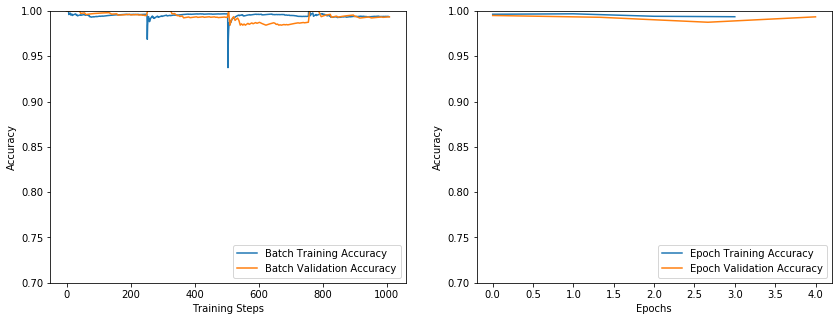

In [72]:
def plot_training_results(training_acc, val_acc, epoch_acc, epoch_val_acc):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=[14, 5])

    # Plot batchs training & validation accuracy
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Training Steps")

    training_steps = len(training_acc)
    test_steps = len(val_acc)
    ax[0].plot(training_acc, label='Batch Training Accuracy')
    ax[0].plot(np.linspace(0, training_steps, test_steps), val_acc, label='Batch Validation Accuracy')
    ax[0].set_ylim([0.7,1])
    ax[0].legend(loc='lower right')

    # Plot epochs training & validation accuracy
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epochs")

    train_epochs = len(epoch_acc)
    val_epochs = len(epoch_val_acc)
    ax[1].plot(epoch_acc, label='Epoch Training Accuracy')
    ax[1].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_acc, label='Epoch Validation Accuracy')
    ax[1].set_ylim([0.7,1])
    ax[1].legend(loc='lower right')

    plt.show()

plot_training_results(batch_stats_callback.batch_acc,      #batch stats
                      batch_stats_callback.batch_val_acc,  #batch stats
                      history.history['accuracy'],         #epoch stats
                      history.history['val_accuracy']      #epoch stats
                     )

## Testing and preview

In [73]:
# Take 1 batch out to test

for image_batch, label_batch in test_set:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 28, 28, 1)
Label batch shape:  (32,)


In [74]:
# Predict
label_names = np.array(label_names)
predicted_batch = cnn_model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]

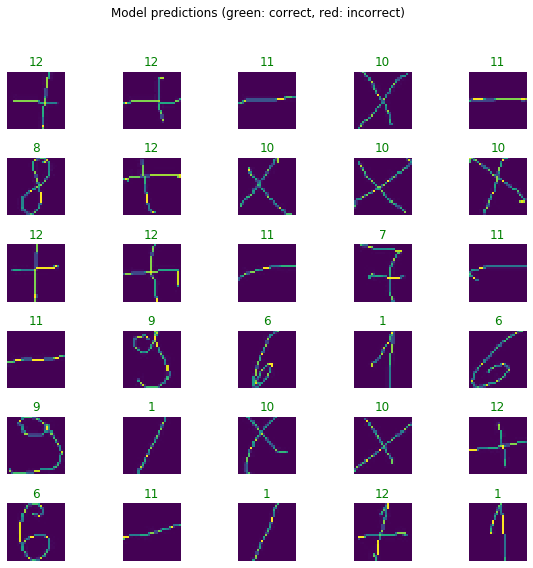

In [66]:
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n][:,:,0])
    color = "green" if predicted_id[n] == label_batch.numpy()[n] else "red"
    plt.title(predicted_label_batch[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export model

In [79]:
# Export model
cnn_model.save('./first_half_mul.h5')

In [80]:
# Test model

reloaded_model = tf.keras.models.load_model('./plus_minus_times_div.h5')
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          2

In [81]:
# test if the current model result and export model result is consistent
result_batch = cnn_model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [82]:
# check if there is any difference
abs(reloaded_result_batch - result_batch).max()

0.0